In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def projective_transform(self,x):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """
        focal = self.f
        sensor = self.c
        
        #General Coordinates
        gcx = x[0]/x[2]
        gcy = x[1]/x[2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv])
      
    
    def rotational_transform(self,X):
        """  
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """
        cam_x = X[0]
        cam_y = X[1]
        cam_z = X[2]
        roll = X[3]
        pitch = X[4]
        yaw = X[5]
        
        r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
        r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
        r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
        r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])

        T = np.array([[1, 0, 0, -cam_x], [0, 1, 0, -cam_y], [0, 0, 1, -cam_z], [0, 0, 0, 1]])

        C = r_axis @ r_roll @ r_pitch @ r_yaw @ T
        
        # pts is not defined, should it be [cam_x, cam_y, cam_z, 1]?
        #pts = np.array([cam_x,cam_y,cam_z,1])
        
        return C @ pts
    
    def estimate_pose(self,X_gcp,u_gcp):
        
        def residual(X_gcp,u_gcp):
            return projective_transform(X_gcp) - u_gcp
        
        # Initial guess of X_gcp
        p_0 = np.array([0,0,0,0,0])
        
        # Minimize X_gcp
        p_opt = so.least_squares(residual, p_0, method='lm',args=(X_gcp,u_gcp))['X_gcp']
        
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        pass

In [2]:
# Initialize the camera and it's attributes from .exif file
myCam = Camera()
#Fixme!!
#myCam.f = 1000
#myCam.c = np.array([2000.,1000.])


# Read in gcp's from file
f = open('image_coordinates.txt', 'r')
for line in f:
    # Remove newline characters
    line = line.replace("\n", "")
    # Delimit by comma
    line = line.split(',')
   
    print(line)


# Project the image with gcp's labeled by optimizing X_gcp


['u', 'v', '323479', '4306481', '182', 'Top of Washington Memorial']
['u', 'v', '323024', '4306503', '3', 'Bottom of fountain']
['u', 'v', '324286', '4306580', '37', 'Round dome in background - Natural History Museum']
['u', 'v', '324164', '4306990', '85', 'Point of tall building in background left']
['u', 'v', '323017', '4306515', '22', 'Top of flag pole in left of picture frame']


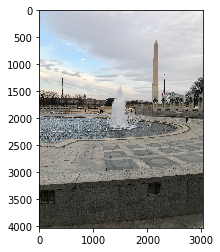

In [6]:
im = plt.imshow(mpimg.imread('national_mall.jpg'))